# Tutorial 8: Bilateral filter and NLM

## Introduction

See slides.

In [9]:
import cv2
import skimage.measure
from matplotlib import pyplot as plt
import numpy as np
import sklearn.decomposition
import sklearn.neighbors

## Bilateral filter

We will begin by uploading an image and contaminating it with white noise.

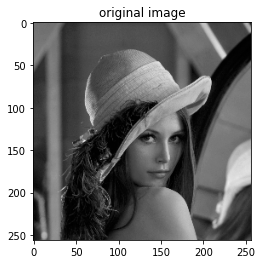

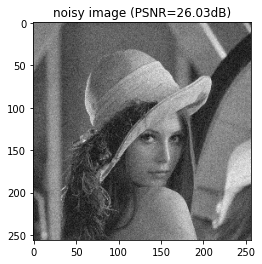

In [10]:
WHITE_LEVEL = 255
SIZE = 256
NOISE_STD = 0.05

image = cv2.imread('lena.jpg', cv2.IMREAD_GRAYSCALE) / WHITE_LEVEL
image = cv2.resize(image, (SIZE, SIZE))
plt.imshow(image, cmap='gray')
plt.title('original image')
plt.show()

noisy_image = image + np.random.normal(scale=NOISE_STD, size=image.shape)
noisy_psnr = skimage.measure.compare_psnr(image, noisy_image)
plt.imshow(noisy_image, cmap='gray')
plt.title(f'noisy image (PSNR={noisy_psnr:.2f}dB)')
plt.show()

Let's try denoising it in a naive manner, using a Gaussian low-pass filter.

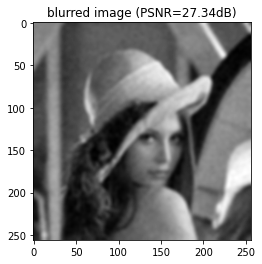

In [11]:
BLUR_FILTER_SIZE = 7
BLUR_FILTER_STD = 2

blurred_image = cv2.GaussianBlur(noisy_image, (BLUR_FILTER_SIZE, BLUR_FILTER_SIZE), BLUR_FILTER_STD)
blurred_psnr = skimage.measure.compare_psnr(image, blurred_image)
plt.imshow(blurred_image, cmap='gray')
plt.title(f'blurred image (PSNR={blurred_psnr:.2f}dB)')
plt.show()

The edges of the image got smudged!

Let's try using the bilateral filter this time.

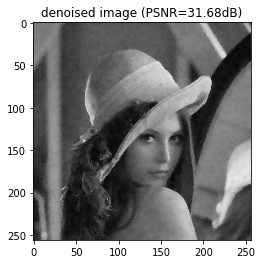

In [12]:
BILATERAL_FILTER_SIZE = 7
BILATERAL_FILTER_SPACE_STD = 2
BILATERAL_FILTER_RANGE_STD = 0.1

def gaussian_distance(x, y, sigma):
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * sigma ** 2))

def calculate_weight(image, i, j, k, l, sigma_r, sigma_s):
    intensity_distance = gaussian_distance(image[i][j], image[k][l], sigma_r)
    location_distance = gaussian_distance(np.array((i, j, )), np.array((k, l, )), sigma_s)
    return intensity_distance * location_distance

def bilateral_filter(image, diameter, sigma_r, sigma_s):
    radius = (diameter - 1) // 2
    height, width = image.shape
    output = np.zeros(image.shape)
    for i in range(height):
        for j in range(width):
            pixel_sum = 0
            weight_sum = 0
            for k in range(max(0, i - radius), min(height, i + radius + 1)):
                for l in range(max(0, j - radius), min(width, j + radius + 1)):
                    weight = calculate_weight(image, i, j, k, l, sigma_r, sigma_s)
                    weight_sum += weight
                    pixel_sum += weight * image[k, l]
                               
            output[i, j] = pixel_sum / weight_sum

    return output

denoised_image = bilateral_filter(noisy_image, BILATERAL_FILTER_SIZE, BILATERAL_FILTER_RANGE_STD, BILATERAL_FILTER_SPACE_STD)
denoised_psnr = skimage.measure.compare_psnr(image, denoised_image)
plt.imshow(denoised_image, cmap='gray')
plt.title(f'denoised image (PSNR={denoised_psnr:.2f}dB)')
plt.show()

## NLM

Let's upload a new image with noticeable self-similarity and repeating patterns, and contaminate it with noise.

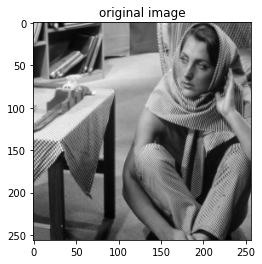

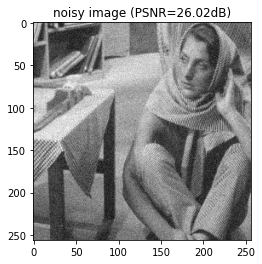

In [13]:
WHITE_LEVEL = 255
SIZE = 256
NOISE_STD = 0.05

image = cv2.imread('barbara.png', cv2.IMREAD_GRAYSCALE) / WHITE_LEVEL
image = cv2.resize(image, (SIZE, SIZE))
plt.imshow(image, cmap='gray')
plt.title('original image')
plt.show()

noisy_image = image + np.random.normal(scale=NOISE_STD, size=image.shape)
noisy_psnr = skimage.measure.compare_psnr(image, noisy_image)
plt.imshow(noisy_image, cmap='gray')
plt.title(f'noisy image (PSNR={noisy_psnr:.2f}dB)')
plt.show()

Let's try using the bilateral filter again.

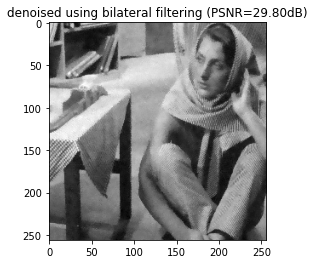

In [14]:
BILATERAL_FILTER_SIZE = 7
BILATERAL_FILTER_SPACE_STD = 2
BILATERAL_FILTER_RANGE_STD = 0.1

bf_image = bilateral_filter(noisy_image, BILATERAL_FILTER_SIZE, BILATERAL_FILTER_RANGE_STD, BILATERAL_FILTER_SPACE_STD)
bf_psnr = skimage.measure.compare_psnr(image, bf_image)
plt.imshow(bf_image, cmap='gray')
plt.title(f'denoised using bilateral filtering (PSNR={bf_psnr:.2f}dB)')
plt.show()

Because of the similarity between the patches, we can expect better results using NLM. Let's try.

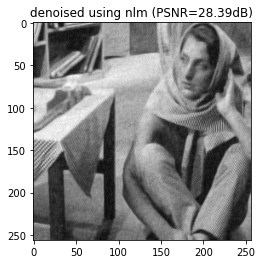

In [16]:
PATCH_SIZE = 5
REDUCED_PATCH_SIZE = 10
NLM_RANGE_STD = 0.3

def nlm(image, patch_size, reduced_patch_size, sigma_r, num_neighbors=10):
    radius = patch_size // 2
    height, width = image.shape

    padded_image = np.pad(image, radius, mode='reflect')
    patches = np.zeros((height * width, patch_size ** 2, ))
    for i in range(radius, height + radius):
        for j in range(radius, width + radius):
            patch = padded_image[i - radius:i + radius + 1, j - radius:j + radius + 1]
            patches[(i - radius) * width + (j - radius), :] = patch.flatten()

    transformed_patches = sklearn.decomposition.PCA(n_components=reduced_patch_size).fit_transform(patches)
    tree = sklearn.neighbors.BallTree(transformed_patches, leaf_size=2)
    output = np.zeros_like(image)
    for i in range(height):
        for j in range(width):
            patch_index = i * width + j
            patch = patches[patch_index]
            representative_patch = np.expand_dims(transformed_patches[patch_index], 0)
            _, neighbor_indices = tree.query(representative_patch, k=num_neighbors)
            neighbor_indices = neighbor_indices[0, 1:]
            pixel_indices = np.array([
                (neighbor_index // width, neighbor_index % width)
                for neighbor_index in neighbor_indices
            ])
            
            pixels = image[pixel_indices[:, 0], pixel_indices[:, 1]]
            weights = np.array([
                gaussian_distance(patch, patches[neighbor_index], sigma_r)
                for neighbor_index in neighbor_indices
            ])
            
            output[i, j] = np.sum(weights * pixels) / np.sum(weights)

    return output
                                  
nlm_image = nlm(noisy_image, PATCH_SIZE, REDUCED_PATCH_SIZE, NLM_RANGE_STD)
nlm_psnr = skimage.measure.compare_psnr(image, nlm_image)
plt.imshow(nlm_image, cmap='gray')
plt.title(f'denoised using nlm (PSNR={nlm_psnr:.2f}dB)')
plt.show()

The square patterns in the scarf, pants, table cloth and curtain look better, but the noise on the floor and wall looks like these patterns as well. It seems that the patches of noise on the white material were too similar to the patches with the square patterns, resulting with inappropriate weights. We might mitigate this issue by multiplying the weights with Gaussians estimated over the spatial differences.